In [1]:
#Imports
import numpy as np
import pandas as pd

from utils.graph_utils import *

# Define graph Structure

- define graph and which shift and intercept terms to use


In [2]:
# toy example  https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal

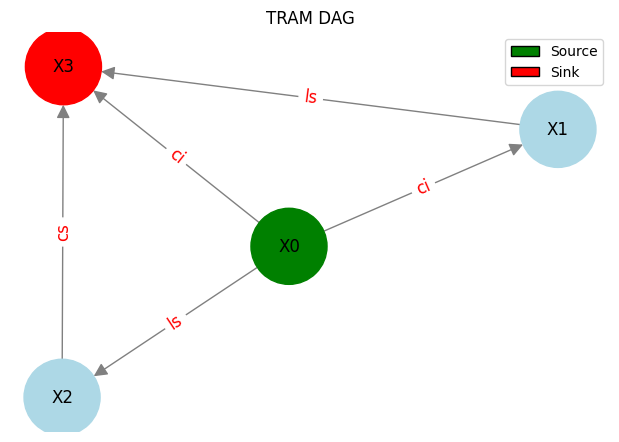

In [3]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 



# # Example 1 3x3:
# data_type={'X0':'cont','X1':'other','X2':'ord'}  # images, continous, continous, continous
# adj_matrix = np.array([
#     [ "0", "0", "ci"],  # A -> B (cs), A -> C (ls)
#     [ "0", "0", "cs"],  # B -> D (ls)
#     [ "0", "0", "0"],  # C -> D (cs)
# ], object)


# example 2 4x4
data_type={'X0':'other','X1':'ord','X2':'ord','X3':'ord'}  # images, continous, continous, continous    
adj_matrix = np.array([
                                ["0", "ci", "ls", "ci"],  # A -> B (cs), A -> C (ls)
                                ["0", "0", "0", "ls"],  # B -> D (ls)
                                ["0", "0", "0", "cs"],  # C -> D (cs)
                                ["0", "0", "0", "0"]    # No outgoing edges from D
                            ], dtype=object)


plot_dag(adj_matrix,data_type, seed=42)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


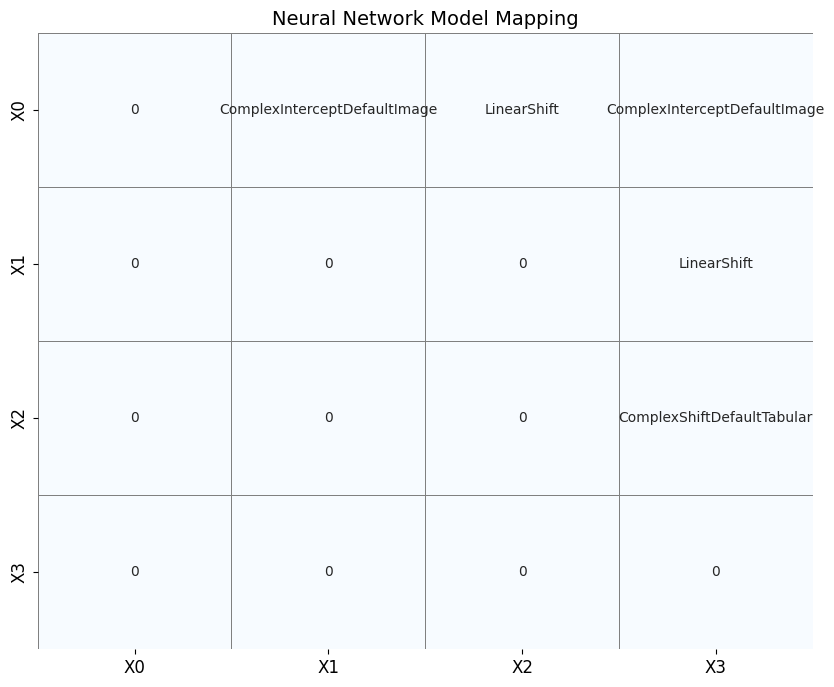

In [4]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix)
## BUG has bug does not find the correct modelnames for the nn image should have x= -X1 should be cS imagedate defalut

In [5]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

In [6]:
configuration_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
configuration_dict

{'X0': {'Modelnr': 0,
  'data_type': 'other',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'X1': {'Modelnr': 1,
  'data_type': 'ord',
  'node_type': 'internal',
  'parents': ['X0'],
  'parents_datatype': ['other'],
  'transformation_terms_in_h()': {'X0': 'ci'},
  'transformation_term_nn_models_in_h()': {'X0': 'ComplexInterceptDefaultImage'}},
 'X2': {'Modelnr': 2,
  'data_type': 'ord',
  'node_type': 'internal',
  'parents': ['X0'],
  'parents_datatype': ['other'],
  'transformation_terms_in_h()': {'X0': 'ls'},
  'transformation_term_nn_models_in_h()': {'X0': 'LinearShift'}},
 'X3': {'Modelnr': 3,
  'data_type': 'ord',
  'node_type': 'sink',
  'parents': ['X0', 'X1', 'X2'],
  'parents_datatype': ['other', 'ord', 'ord'],
  'transformation_terms_in_h()': {'X0': 'ci', 'X1': 'ls', 'X2': 'cs'},
  'transformation_term_nn_models_in_h()': {'X0': 'ComplexInterceptDefaultImage',
   'X1': '

## Fit models

- each model independently fitting

In [7]:
from utils.ontram_models import *

In [8]:
# for each model 

# - create the ontram model 
 
# - create the dataloaders train val
 
 
#  -fit model and save weights..

In [27]:
def merge_transformation_dicts(transformation_terms_in_h, transformation_term_nn_models_in_h):
    """
    Merges two dictionaries by key, creating a unified structure where each key maps to a dictionary 
    containing both 'h' (from transformation_terms_in_h) and 'modelname' (from transformation_term_nn_models_in_h).

    Args:
        transformation_terms_in_h (dict): Dictionary with transformation terms.
        transformation_term_nn_models_in_h (dict): Dictionary with corresponding model names.

    Returns:
        dict: A merged dictionary where each key maps to {'h': value from transformation_terms_in_h, 
              'modelname': value from transformation_term_nn_models_in_h}.
    """
    merged_dict = {
        key: {
            "h_term": transformation_terms_in_h.get(key, None),  # Get value from first dict, default to None if missing
            "class_name": transformation_term_nn_models_in_h.get(key, None)  # Get value from second dict
        }
        for key in transformation_terms_in_h.keys()  # Iterate over keys from the first dict
    }
    return merged_dict

In [ ]:
for node in configuration_dict:
    print(f'\n----------node {node}--------')
    
    
    
    ################################## 1. Create Ontram Model
    # TODO add args to the models via config file eg nn_int = globals()[nn_int_name](args) , args from conf
    
    
    ### iF node is a source -> no deep nn is needed
    if configuration_dict[node]['node_type'] == 'source':
        print('source node --> only  modelled only  by si')
        nn_int = SimpleIntercept()
        ontram_model = OntramModel(nn_int, None)  
        
    ### if node is not a source node 
    else:
        # read terms and model names form the config
        terms_dict=configuration_dict[node]['transformation_terms_in_h()']
        model_names_dict=configuration_dict[node]['transformation_term_nn_models_in_h()']

        # Combine terms and model names and divide in intercept and shift terms
        model_dict=merge_transformation_dicts(terms_dict, model_names_dict)
        intercepts_dict = {k: v for k, v in model_dict.items() if "ci" in v['h_term'] or 'si' in v['h_term']}        
        shifts_dict = {k: v for k, v in model_dict.items() if "ci" not in v['h_term'] and  'si' not in v['h_term']}        
        
        # make sure that nns are correctly defined afterwards
        nn_int, nn_shifts_list = None, None

        # intercept term
        if not np.any(np.array([True for diction in intercepts_dict.values() if 'ci' in diction['h_term']]) == True):
            print('No ci detected --> intercept defaults to si')
            nn_int = SimpleIntercept()
            
        else:
            
            # intercept term -> model
            nn_int_name = list(model_names_dict.items())[0][1]
            nn_int = globals()[nn_int_name]()
        
            # shift term -> lsit of models         
            nn_shift_names=[v["class_name"] for v in shifts_dict.values() if "class_name" in v]
            nn_shifts_list = [globals()[name]() for name in nn_shift_names]
            
        
            # ontram model
            ontram_model = OntramModel(nn_int, nn_shifts_list)    
            print(ontram_model)
        
    ############################### 2. Create Dataloaders
    
    
    
    
    
    # 1. search the Intercept model 
    # 2. search the shift models     
    # 3. put them into a list to create the onttram model 
    # 4. create the dataloaders according to that list
        
    
    
        
    # # Dynamically instantiate models from dictionary
    # nn_int = globals()[nn_model_names_dict['X0']]()  # Intercept model
    # nn_shift = [globals()[nn_model_names_dict['X1']]()]  # Shift models (list)

    # # Initialize OntramModel
    # ontram_model = OntramModel(nn_int, nn_shift)




----------node X0--------
source node --> only  modelled only  by si

----------node X1--------
OntramModel(
  (nn_int): ComplexInterceptDefaultImage(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=784, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=20, bias=False)
  )
  (nn_shift): ModuleList()
)

----------node X2--------
No ci detected --> intercept defaults to si

----------node X3--------
OntramModel(
  (nn_int): ComplexInterceptDefaultImage(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
[v["class_name"] for v in merged_dict.values() if "class_name" in v]


{'X1': {'h_term': 'ls', 'class_name': 'LinearShift'},
 'X2': {'h_term': 'cs', 'class_name': 'ComplexShiftDefaultTabular'}}

# Sample